In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [159]:
# Assumming watermark is a 100x100 region in the center
wm_imgs = []
clean_imgs = []

In [160]:
for file in os.listdir('labeled'):
    img = cv2.imread(f'labeled/{file}', cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    if file.startswith('clean'):
        clean_imgs.append(img)
    else:
        wm_imgs.append(img)
    

In [161]:
wm_arr = np.stack(wm_imgs)
clean_arr = np.stack(clean_imgs)
print(f"watermark images shape: {wm_arr.shape} | clean images shape: {clean_arr.shape}")

watermark images shape: (69, 256, 256) | clean images shape: (71, 256, 256)


In [162]:
wm_mean = wm_arr.mean(axis=0)
clean_mean = clean_arr.mean(axis=0)
mean_diff = np.abs(wm_mean - clean_mean)

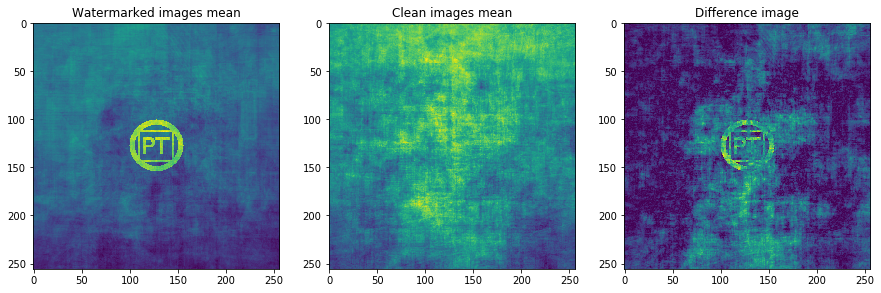

In [163]:
f, ax = plt.subplots(ncols=3, figsize=(15,8))
ax[0].set_title("Watermarked images mean")
ax[0].imshow(wm_mean.astype('uint8'))

ax[1].set_title("Clean images mean")
ax[1].imshow(clean_mean.astype('uint8'))

ax[2].set_title("Difference image")
ax[2].imshow(mean_diff.astype('uint8'));

In [164]:
wm_mask = (wm_mean > np.percentile(wm_mean, 98))

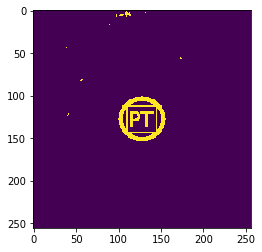

In [165]:
plt.imshow(wm_mask.astype('float'))

In [166]:
def rmse(img1, img2):
    return np.sqrt(np.sum((img1 - img2) ** 2))

In [179]:
def decision_rmse(img, clean_mean, wm_mean):
    clean_rmse = rmse(img, clean_mean)
    wm_rmse = rmse(img, wm_mean)
    if wm_rmse < clean_rmse:
        return 1
    else:
        return 0

def decision_mask_mean(img, clean_mean, wm_mean):
#     print(img.mean(), img[wm_mask].mean())
    if img.mean() < img[wm_mask].mean():
        return 1
    else:
        return 0

def decision_rule(img, clean_mean, wm_mean):
    decision = .3 * decision_rmse(img, clean_mean, wm_mean) + .7 * decision_mask_mean(img, clean_mean, wm_mean)
    return "watermark" if decision > .5 else "clean"

In [180]:
correct_classification = 0
n = wm_arr.shape[0] + clean_arr.shape[0]
for wm_img in wm_arr:
    decision = decision_rule(wm_img, clean_mean, wm_mean)
    if decision == "watermark":
        correct_classification += 1

for clean_img in clean_arr:
    decision = decision_rule(clean_img, clean_mean, wm_mean)
    if decision == "clean":
        correct_classification += 1

print("Accuracy =", correct_classification / n)

Accuracy = 0.6642857142857143


### Logistic Regression application

In [217]:
import sklearn
from sklearn.linear_model import LogisticRegression

In [194]:
X = np.concatenate([wm_arr, clean_arr])

In [196]:
X = X.reshape((X.shape[0], 256 * 256))

In [215]:
Y = np.concatenate([np.ones((wm_arr.shape[0], 1)), np.zeros((clean_arr.shape[0], 1))]).ravel()

In [218]:
model = LogisticRegression()
model.fit(X, Y)
Y_pred = model.predict(X)

/home/ptyshevskyi/envs/cv4/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [227]:
# Accuracy
print("Accuracy =", (model.predict(X) == Y).sum() / Y.shape[0])

1.0